In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import time
from scipy.stats import norm
import datetime as dt

from vax_sims_LHS_samples import *
from plot_utils import *

In [2]:
def load_sim_output(folder, npoints, lb=0):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS+['student_inf_10','student_inf_50','student_inf_90']+\
                                ['staff_inf_10', 'staff_inf_50', 'staff_inf_90'])
    for idx in range(lb, npoints):
        inf_file = folder + '/list_of_infs_by_group_{}.dill'.format(idx)
        point_file = folder + '/lhs_point_{}.dill'.format(idx)
        with open(inf_file, 'rb') as fhandle:
            inf_matrix = np.array(dill.load(fhandle))
            student_infxns = np.sum(inf_matrix[:,:-2], axis=1)
            staff_infxns = np.sum(inf_matrix[:,-2:], axis=1)
        with open(point_file, 'rb') as fhandle:
            uncertainty_point = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
        new_row['student_inf_10'] = np.quantile(student_infxns, 0.1)
        new_row['student_inf_50'] = np.quantile(student_infxns, 0.5)
        new_row['student_inf_90'] = np.quantile(student_infxns, 0.9)
        new_row['staff_inf_10'] = np.quantile(staff_infxns, 0.1)
        new_row['staff_inf_50'] = np.quantile(staff_infxns, 0.5)
        new_row['staff_inf_90'] = np.quantile(staff_infxns, 0.9)
        new_row['cornell_inf_10'] = np.quantile(student_infxns + staff_infxns, 0.1)
        new_row['cornell_inf_50'] = np.quantile(student_infxns + staff_infxns, 0.5)
        new_row['cornell_inf_90'] = np.quantile(student_infxns + staff_infxns, 0.9)
        
        scenario_data = scenario_data.append(new_row, ignore_index=True)

    return scenario_data

def residential_regression_student(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'student_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results

def residential_regression_staff(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'staff_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results


In [3]:
def calculate_pessimistic_scenario(results, q=0.99, beta=1.96):
    # the keys in dict(results.params) specify whether this is for residential
    # or virtual vs. residential
    lr_results = dict(results.params)
    sd_dict = dict()
    pess_direction = dict()
    params = set(lr_results.keys()) - set(['const'])
    centre_infections = lr_results['const']

    invquantile = norm.ppf(q)

    for param in params:
        sd_dict[param] = (UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*beta)
        centre_infections += np.mean(UNCERTAINTY_PARAM_RANGES[param]) * lr_results[param]

    sum_squares_Sigma_1 = 0

    for param in params:
        sum_squares_Sigma_1 += (lr_results[param]*sd_dict[param]) ** 2

    for param in params:
        pess_direction[param] = lr_results[param]*(sd_dict[param])**2 / np.sqrt(sum_squares_Sigma_1)

    mp_pess_scenario = dict()
    for param in params:
        mp_pess_scenario[param] = np.mean(UNCERTAINTY_PARAM_RANGES[param]) + invquantile * pess_direction[param]

    return mp_pess_scenario

In [4]:
LHS_data = load_sim_output('lhs_vax_sims_test_delay:1631153818.0076091', 200)
lr_results = residential_regression_student(LHS_data)

In [5]:
param_modifiers = {'ug_ga_vax_test_frequency': 2/7, 'ug_ga_unvax_test_frequency': 2/7,
            'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
            'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
            'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7,
            'test_delay': 1}

In [6]:
def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0]-1].sum()


def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)


def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_trajs_by_group = []
    for group in sim.sims:
        df = group.sim_df
        inf_trajs_by_group.append(get_cum_inf_trajectory(df))
    return inf_trajs_by_group


def get_centre_point():
    centre = {}
    for param in UNCERTAINTY_PARAM_RANGES:
        lb, ub = UNCERTAINTY_PARAM_RANGES[param]
        centre[param] = (lb + ub) / 2
    return centre


def run_multiple_trajs(sim, T, n):
    infs_by_group_list = []
    for _ in range(n):
        infs_by_group = run_multigroup_sim(sim,T)
        infs_by_group_list.append(infs_by_group)
    return infs_by_group_list

### Run Simulation 

In [7]:
# params
Q_LIST = np.arange(0.05, 0.4, 0.05)
M_LIST = np.arange(1, 2.5, 0.1)
T=112 # 112
n=50 # 50

In [8]:
def run_sim(q,m,sim,T,n,return_dict):
    return_dict[(q,m)]=run_multiple_trajs(sim, T=T, n=n)

In [9]:
manager = multiprocessing.Manager()
return_dict = manager.dict()
processes = []
for q in Q_LIST:
    scenario = calculate_pessimistic_scenario(lr_results, q=q)
    point = [scenario['vax_susc_mult'], scenario['vax_transmission_mult'],
             scenario['contacts_per_day_mult'], scenario['outside_infection_rate_mult'],
             scenario['cases_isolated_per_contact_trace']]
    for m in M_LIST:
        print('Running q=%.2f, m=%.2f' % (q,m))
        vax_sim = map_lhs_point_to_vax_sim(point, param_modifiers, tr_mult=m)

        # parallel processing
        # inf_trajs_by_group = run_multiple_trajs(vax_sim, T=T, n=n)
        p = Process(target = run_sim, args=(q, m, vax_sim, T, n, return_dict))
        p.start()
        processes.append(p)
    
# wait until all processes are dead 
for p in processes:
    p.join()

Running q=0.05, m=1.00


/home/hwr26/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/hwr26/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Running q=0.05, m=1.10
Running q=0.05, m=1.20
Running q=0.05, m=1.30
Running q=0.05, m=1.40
Running q=0.05, m=1.50
Running q=0.05, m=1.60
Running q=0.05, m=1.70
Running q=0.05, m=1.80
Running q=0.05, m=1.90
Running q=0.05, m=2.00
Running q=0.05, m=2.10
Running q=0.05, m=2.20
Running q=0.05, m=2.30
Running q=0.05, m=2.40
Running q=0.10, m=1.00
Running q=0.10, m=1.10
Running q=0.10, m=1.20
Running q=0.10, m=1.30
Running q=0.10, m=1.40
Running q=0.10, m=1.50
Running q=0.10, m=1.60
Running q=0.10, m=1.70
Running q=0.10, m=1.80
Running q=0.10, m=1.90
Running q=0.10, m=2.00
Running q=0.10, m=2.10
Running q=0.10, m=2.20
Running q=0.10, m=2.30
Running q=0.10, m=2.40
Running q=0.15, m=1.00
Running q=0.15, m=1.10
Running q=0.15, m=1.20
Running q=0.15, m=1.30
Running q=0.15, m=1.40
Running q=0.15, m=1.50
Running q=0.15, m=1.60
Running q=0.15, m=1.70
Running q=0.15, m=1.80
Running q=0.15, m=1.90
Running q=0.15, m=2.00
Running q=0.15, m=2.10
Running q=0.15, m=2.20
Running q=0.15, m=2.30
Running q=0

###  Analysis

In [35]:
X = Q_LIST
Y = M_LIST
Z = np.zeros((len(Q_LIST), len(M_LIST)))
for i in range(len(Q_LIST)):
    for j in range(len(M_LIST)):
        res = return_dict[(Q_LIST[i], M_LIST[j])]
        Z[i,j] = np.mean([np.sum([list(g)[-1] for g in trial]) for trial in res])

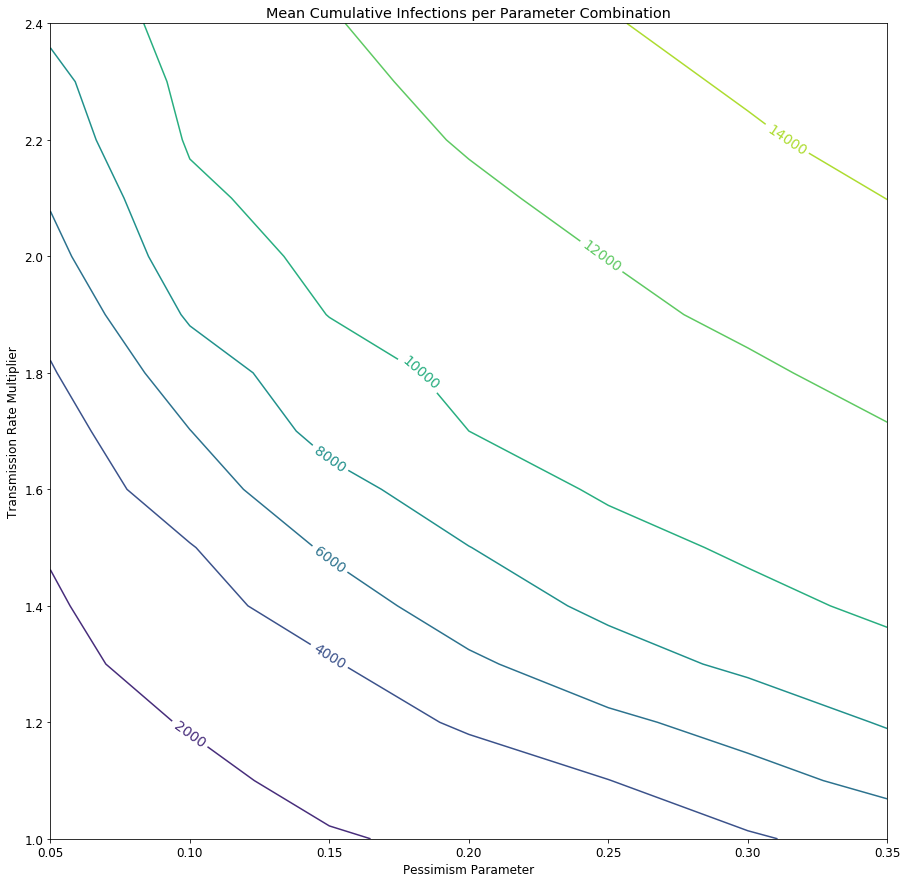

In [37]:
plt.figure(figsize=(15,15))
CS = plt.contour(X, Y, Z.T)  # use levels if needed
plt.clabel(CS, inline=1, fmt='%d', fontsize=14)
plt.xlabel("Pessimism Parameter")
plt.ylabel("Transmission Rate Multiplier")
plt.title("Mean Cumulative Infections per Parameter Combination")
plt.show()